In [1]:
import torch
from ppuu.data.dataloader import Dataset, DataStore, Normalizer
from torch.utils.data import DataLoader

# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/traffic-data_offroad/state-action-cost/data_i80_v0/"
# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/traffic-data_offroad_50_test_train_same/state-action-cost/data_i80_v0/"
ds_path = "/home/us441/nvidia-collab/vlad/traffic-data-5-small/state-action-cost/data_i80_v0/"
# ds_path = "/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/"

data_store = DataStore(ds_path)

dataset = Dataset(
    data_store, "val", 20, 30, size=1000, normalize=False, shift=False, random_actions=False, state_diffs=True
)

loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
)
liter = iter(loader)

batch = next(liter)

In [22]:
from ppuu.data.dataloader import Dataset, DataStore, Normalizer
normalizer = Normalizer(data_store.stats)

In [23]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [24]:
def plot_images(images):
    images = images.detach().cpu().numpy()
    step = max(images.shape[1] // 10, 1)
    l = images.shape[1] // step
    f, axs = plt.subplots(1, l, dpi=200)
    for i in range(max(l, 1)):
        image = np.transpose(images[0][i * step], (1, 2, 0))
        if l == 1:
            axs.imshow(image)
            axs.set_axis_off()
        else:
            axs[i].imshow(image)
            axs[i].set_axis_off()

In [25]:
from ppuu.costs import PolicyCost

from ppuu.lightning_modules.policy.mpur import ForwardModelV3

fm = ForwardModelV3("/home/us441/nvidia-collab/vlad/results/fm/km_no_action/fm_km_no_action_diff_64_even_lower_lr/seed=42/checkpoints/last.ckpt", diffs=False)

fm = fm.cuda()
fm.device = torch.device('cuda:0')

# cost = PolicyCost(PolicyCost.Config(), fm, data_store.stats)
# cost.estimate_uncertainty_stats(loader)
# predictions = batch.copy()
# predictions['pred_images'] = batch['target_images']
# predictions['pred_states'] = batch['target_states']
# predictions['pred_actions'] = batch['actions']
# predictions['Z'] = 

In [26]:
from ppuu.costs import PolicyCost
import ppuu.costs.policy_costs_km
from ppuu.costs import PolicyCostContinuous
import imp
imp.reload(ppuu.costs.policy_costs_km)


<module 'ppuu.costs.policy_costs_km' from '/home/us441/work/forked/ppuu/costs/policy_costs_km.py'>

In [38]:
CostType = ppuu.costs.policy_costs_km.PolicyCostKMTaper
cost = CostType(CostType.Config(), fm, normalizer)
# cost.estimate_uncertainty_stats(loader)

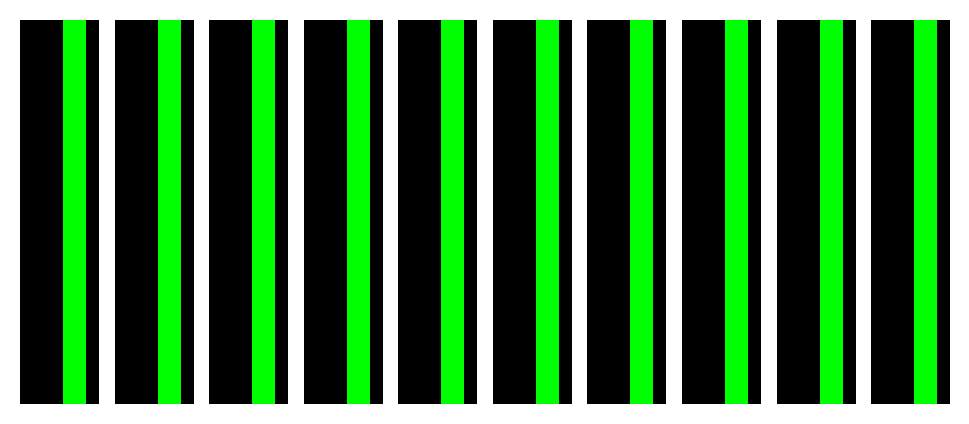

In [39]:
cnd_car_in_front = torch.zeros_like(batch['input_images'])
target_car_in_front = torch.zeros_like(batch['target_images'])

car_slice = slice(13, 20) # to the right
# car_slice = slice(4, 11) # to the left
# car_slice = slice(0, 24)
# car_slice_x = slice(70, 85) # behind
# car_slice_x = slice(20, 35) # in front
car_slice_x = slice(0, 117) # everywhere
cnd_car_in_front[:, :, 1, car_slice_x, car_slice] = 1
target_car_in_front[:, :, 1, car_slice_x, car_slice] = 1
plot_images(cnd_car_in_front)
dummy_images = target_car_in_front[:1, :2]

In [40]:
actions = torch.tensor([[1.0, 1], [1.0, 1]], requires_grad=True, device='cuda')
dummy_stats = {}
for k in data_store.stats:
    if 'a_' not in k:
        if 'std' in k:
            dummy_stats[k] = torch.ones_like(data_store.stats[k])
        else:
            dummy_stats[k] = torch.zeros_like(data_store.stats[k])
    else:
        dummy_stats[k] = data_store.stats[k]

In [41]:
dummy_stats

{'a_mean': tensor([ 6.4967e-01, -1.1533e-05]),
 'a_std': tensor([4.8506e+00, 8.6995e-04]),
 's_mean': tensor([0., 0., 0., 0., 0.]),
 's_std': tensor([1., 1., 1., 1., 1.]),
 's_diff_mean': tensor([0., 0., 0., 0., 0.]),
 's_diff_std': tensor([1., 1., 1., 1., 1.])}

In [42]:
print(dummy_stats['s_diff_std'].shape)
print(data_store.stats['s_diff_std'].shape)

torch.Size([5])
torch.Size([5])


In [43]:
data_store.stats

{'a_mean': tensor([ 6.4967e-01, -1.1533e-05]),
 'a_std': tensor([4.8506e+00, 8.6995e-04]),
 's_mean': tensor([ 8.7752e+02,  1.0977e+02,  9.9971e-01, -5.4214e-03,  6.1148e+01]),
 's_std': tensor([3.9319e+02, 4.1908e+01, 1.0230e-03, 2.4421e-02, 2.0400e+01]),
 's_diff_mean': tensor([ 6.1052e+00, -3.3049e-02,  9.9971e-01, -5.4429e-03,  6.1133e+01]),
 's_diff_std': tensor([2.0363e+00, 1.3829e-01, 1.0243e-03, 2.4426e-02, 2.0384e+01])}

In [44]:
import ppuu.modeling.km
import imp 
imp.reload(ppuu.modeling.km)
predict_states_diff = ppuu.modeling.km.predict_states_diff
predict_states = ppuu.modeling.km.predict_states


init_state = torch.tensor([0.0, 0.0, 1.0, 0.0, 66.0]).cuda()
next_state_0 = predict_states(init_state.unsqueeze(0), actions[0].unsqueeze(0), Normalizer.dummy())
next_state_1 = predict_states(next_state_0, actions[1].unsqueeze(0), Normalizer.dummy())

In [45]:
next_state_1.shape
next_states = torch.cat([next_state_0, next_state_1])
print(next_states)

tensor([[ 6.6000,  0.0000,  0.1498, -0.9887, 66.1000],
        [ 7.5902, -6.5354, -0.9552, -0.2960, 66.2000]], device='cuda:0',
       grad_fn=<CatBackward>)


In [60]:
ref_states = init_state.unsqueeze(0).repeat(2, 1)
cost.data_stats = dummy_stats
masks_0 = cost.get_masks(dummy_images.cuda(),
                         next_states, 
                         actions,
                         batch['car_sizes'], 
                         unnormalize=True,
                         ref_states=ref_states
                         )[0]

Seems like the car is outside the state image.


In [61]:
ref_states.shape

torch.Size([2, 5])

In [62]:
masks_0.shape

torch.Size([1, 2, 117, 24])

In [63]:
target_car_in_front[:1].shape

torch.Size([1, 30, 3, 117, 24])

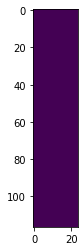

In [64]:
plt.imshow(masks_0[0, 0].detach().cpu())

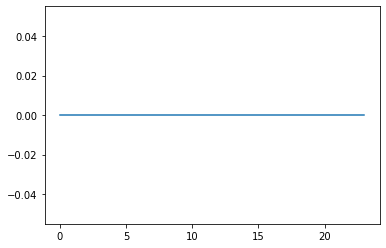

In [65]:
plt.plot(masks_0[0, 0, 50, :].detach().cpu())

In [66]:
coords = torch.linspace(-10, 10, 24)

In [67]:
c = dummy_images[:, :, 1].cuda() * masks_0

In [68]:
c = c.view(*c.shape[:2], -1).sum()
c.backward()

In [69]:
print(actions.grad)

tensor([[0., 0.],
        [0., 0.]], device='cuda:0')


In [70]:
overlaid = dummy_images.cuda() + 0.7 * masks_0.unsqueeze(2)

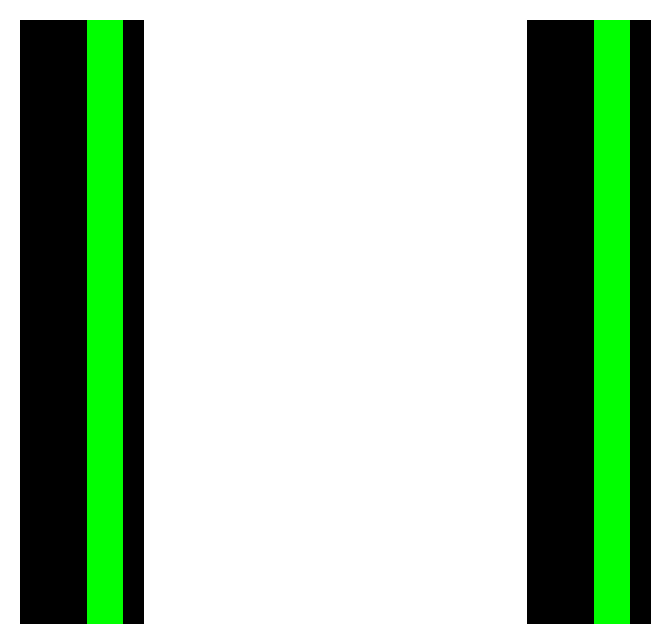

In [71]:
plot_images(overlaid)

In [72]:
x = torch.rand(2) * torch.rand(1) * 100
y = torch.rand(2) * torch.rand(1) * 100
direction = torch.atan2(x[1], x[0])

In [73]:
print(x)

tensor([19.3586, 30.4022])


In [74]:
direction

tensor(1.0038)

In [75]:
dx = torch.cos(direction)
dy = torch.sin(direction)
print(dx, dy)

tensor(0.5371) tensor(0.8435)


In [76]:
v1 = x / torch.norm(x)
v2 = y / torch.norm(y)
print(v1, v2)

tensor([0.5371, 0.8435]) tensor([0.7323, 0.6810])


In [77]:
def rotation_matrix(v1, v2):
    s1 = v1.shape
    s2 = v2.shape
    v1 = v1.view(-1, 2)
    v2 = v2.view(-1, 2)
    
    rot = torch.stack(
        [v1[:, 0]*v2[:, 0] + v1[:, 1]*v2[:, 1], v2[:, 0] * v1[:, 1] - v1[:, 0] * v2[:, 1],
        -v2[:, 0] * v1[:, 1] + v1[:, 0] * v2[:, 1], v1[:, 0]*v2[:, 0] + v1[:, 1] * v2[:, 1]],
    )
    rot = rot.view(2, 2, -1).permute(2, 0, 1).reshape(*s1[:-1], 2, 2)
    print(rot.shape)
    return rot

def rotate(rotations, directions):
    s = directions.shape
    directions = directions.view(-1, 2, 1)
    rotations = rotations.view(-1, 2, 2)
    res = torch.bmm(rotations, directions).view(*s)
    return res

In [78]:
vv1 = v1.view(1, 1, 2).repeat(5, 3, 1)
vv2 = v2.view(1, 1, 2).repeat(5, 3, 1)

In [79]:
rot = rotation_matrix(vv1, vv2)
rotate(rot, vv1) - vv2

torch.Size([5, 3, 2, 2])


tensor([[[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]],

        [[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]],

        [[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]],

        [[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]],

        [[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]]])

In [80]:
(rot @ v1) - v2

tensor([[[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]],

        [[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]],

        [[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]],

        [[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]],

        [[0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08],
         [0.0000e+00, 5.9605e-08]]])

In [81]:
print(v1.norm())
print(v2.norm())

tensor(1.)
tensor(1.)


In [82]:
LANE_WIDTH_METRES = 3.7
LANE_WIDTH_PIXELS = 24  # pixels / 3.7 m, lane width
# SCALE = 1 / 4
PIXELS_IN_METRE = LANE_WIDTH_PIXELS / LANE_WIDTH_METRES
MAX_SPEED_MS = 130 / 3.6  # m/s
LOOK_AHEAD_M = MAX_SPEED_MS  # meters
LOOK_SIDEWAYS_M = 2 * LANE_WIDTH_METRES  # meters
METRES_IN_FOOT = 0.3048
TIMESTEP = 0.1

crop_w = 240
crop_h = 1170

device = torch.device('cuda')
bsize = 1
npred = 1

y = torch.linspace(
    -LOOK_SIDEWAYS_M, LOOK_SIDEWAYS_M, crop_w, device=device
)
x = torch.linspace(-LOOK_AHEAD_M, LOOK_AHEAD_M, crop_h, device=device)
xx, yy = torch.meshgrid(x, y)
xx = xx.repeat(bsize, npred, 1, 1)
yy = yy.repeat(bsize, npred, 1, 1)

In [83]:
dummy_car = torch.zeros_like(xx)
dummy_car.shape

torch.Size([1, 1, 1170, 240])

In [84]:
dummy_car[:, :, :int(0.45 * crop_h), :int(0.45 * crop_w)] = 1

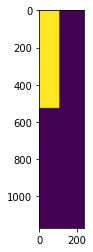

In [85]:
plt.imshow(dummy_car[0, 0].cpu())

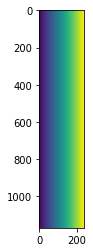

In [86]:
plt.imshow(xx[0, 0].cpu())
plt.imshow(yy[0, 0].cpu())

In [87]:
def curl_around(xx, yy, radii):
    center_y = radii.view(xx.shape[:-2], 1, 1)
    center_x = torch.zeros_like(center_y)
    
    r = torch.sqrt((yy - center_y) ** 2 + (xx - center_x) ** 2)
    x1 = xx - center_x

    is_to_the_right = (center_y > 0).float() * 2 - 1
    y1 = (center_y - yy) * is_to_the_right

    alpha = torch.atan2(x1, y1)
    ll = alpha * r
    yy = center_y - is_to_the_right * r
    xx = center_x + ll
    return xx, yy

def coordinate_rotate(xx, yy, dx, dy):
    c, s = dx, dy 
    c = c.view(xx.shape[:-2], 1, 1)
    s = s.view(xx.shape[:-2], 1, 1)
    x_prime = c * xx - s * yy
    y_prime = s * xx + c * yy
    return x_prime, y_prime


def coordinate_rotate_matrix(xx, yy, matrix):
    """xx, yy - [*dims, H, W]
       matrix - [*dims, 2, 2]
    """
    xy = torch.stack([xx, yy], dim=-1)
    xy = xy.view(-1, 2, 1)
    matrix = matrix.unsqueeze(-3).unsqueeze(-3)
    repeat = [1] * len(matrix.shape)
    repeat[-3] = xx.shape[-1]
    repeat[-4] = xx.shape[-2]
    matrix = matrix.repeat(*repeat).view(-1, 2, 2)
    rotated = torch.bmm(matrix, xy)
    xx = rotated[:, 0].view(xx.shape)
    yy = rotated[:, 1].view(yy.shape)
    return xx, yy

def rotation_matrix(v1, v2):
    s1 = v1.shape
    v1 = v1.view(-1, 2)
    v2 = v2.view(-1, 2)
    rot = torch.stack(
        [
            v1[:, 0] * v2[:, 0] + v1[:, 1] * v2[:, 1],
            v2[:, 0] * v1[:, 1] - v1[:, 0] * v2[:, 1],
            -v2[:, 0] * v1[:, 1] + v1[:, 0] * v2[:, 1],
            v1[:, 0] * v2[:, 0] + v1[:, 1] * v2[:, 1],
        ],
    )
    rot = rot.view(2, 2, -1).permute(2, 0, 1).reshape(*s1[:-1], 2, 2)
    return rot


def coordinate_shift(xx, yy, shift_x, shift_y):
    shift_x = shift_x.view(xx.shape[:-2], 1, 1)
    shift_y = shift_y.view(yy.shape[:-2], 1, 1)
    return xx - shift_x, yy - shift_y

In [88]:
def plot_coord(xx, yy):
    # since we want the positive x to be on top in the image, we flip it.
    xx_r = torch.flip(xx, [-2])
    yy_r = torch.flip(yy, [-2])
#     xx_r = xx
    fig, ax = plt.subplots(1, 8, dpi=150)
    ax[0].imshow(torch.sin(xx_r*2).cpu()[0, 0] > 0.0)
    ax[1].imshow(torch.sin(yy_r*2).cpu()[0, 0] > 0.0)
    ax[2].imshow(torch.cos(xx_r).cpu()[0, 0] * torch.sin(yy_r).cpu()[0, 0] > 0.0)
    ax[3].imshow(xx_r.detach().cpu()[0, 0])
    ax[4].imshow(yy_r.detach().cpu()[0, 0])
    mask = func(xx_r, yy_r)
    ax[5].imshow(mask.detach().cpu()[0, 0])
    ax[6].imshow(dummy_car.cpu()[0, 0])
    ax[7].imshow((mask * dummy_car).detach().cpu()[0, 0])
    for a in ax:
        a.axis('off')
        
def cost(xx, yy):
    xx_r = torch.flip(xx, [-2])
    yy_r = torch.flip(yy, [-2])
    mask = func(xx_r, yy_r)
    return (mask * dummy_car).sum() / mask.sum()

In [89]:

def random_v():
    v1 = torch.rand(2).cuda()
    v1 /= v1.norm()
    return v1


def func(xx, yy):
    xk = torch.clamp((10 - xx.abs()), min=0)
    yk = torch.clamp((3 - yy.abs()), min=0)
    return xk * yk
    

(-0.5, 239.5, 1169.5, -0.5)

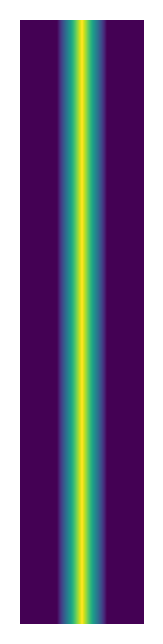

In [98]:
xk = torch.clamp((3 - yy.abs()), min=0)
plt.figure(dpi=200)
plt.imshow(xk.cpu().detach()[0, 0])
plt.axis('off')

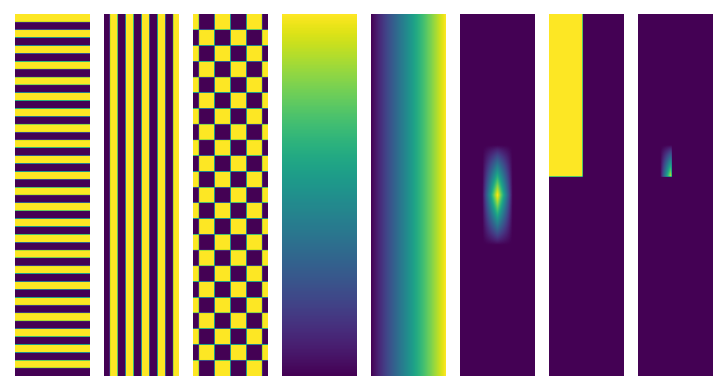

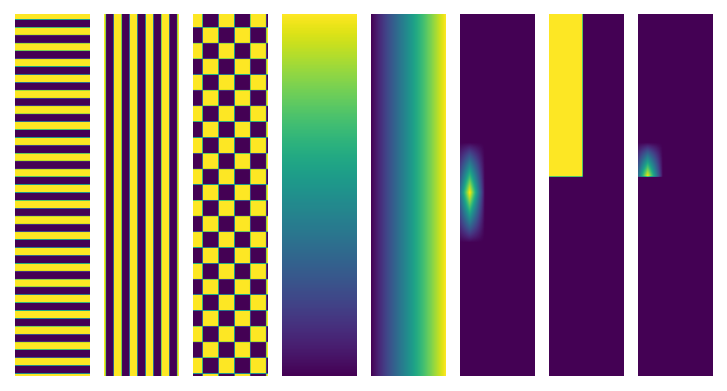

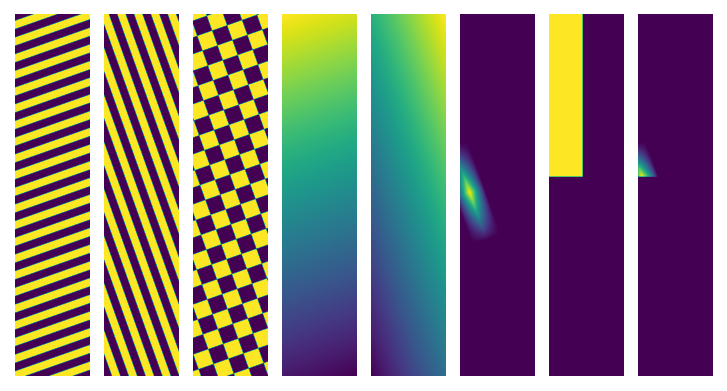

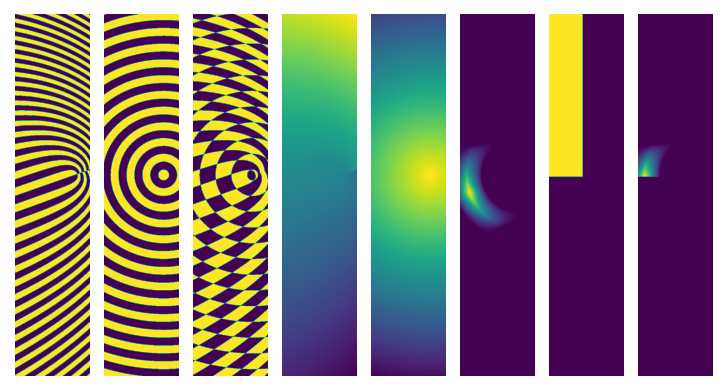

In [90]:
xxr = xx.clone()
yyr = yy.clone()

plot_coord(xxr, yyr)

# Transformation parameters
# 1. rotation
m = rotation_matrix(random_v(), random_v())
m.requires_grad = True

# 2. shift
shift = torch.tensor([0.5, -5.5], device=device, requires_grad=True)

# 3. curling
r = torch.tensor([10.5], device=device, requires_grad=True)

xxr, yyr = coordinate_shift(xxr, yyr, shift[0], shift[1])
plot_coord(xxr, yyr)

xxr, yyr = coordinate_rotate_matrix(xxr, yyr, m)
plot_coord(xxr, yyr)

xxr, yyr = curl_around(xxr, yyr, r)
plot_coord(xxr, yyr)

In [91]:
cost(xxr, yyr).backward()

In [57]:
print('r', r.grad)
print('m', m.grad)
print('shift', shift.grad)

r tensor([0.0078], device='cuda:0')
m tensor([[-0.1623, -0.0988],
        [ 0.2003,  0.1881]], device='cuda:0')
shift tensor([ 0.0801, -0.0374], device='cuda:0')


In [58]:
func(xxr, yyr).sum()

tensor(195595.0625, device='cuda:0', grad_fn=<SumBackward0>)